In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from datasetcontroller.datacontroller import DataController

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import time
import numpy as np

2023-06-07 10:27:50.537614: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-07 10:27:50.573649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 데이터셋 폴더 경로 설정
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# 모델 체크포인트
proj_path = os.path.join(path,'repos','cmaqProject')
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_pixlasso_v1_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 컨트롤러
datacontroller = DataController(data_path = data_path)

# 기본 control matrix, smoke, cmaq 데이터셋 
control_matrix, _, target_arr = datacontroller.get_yearly_dataset()
X_train, X_test, y_train, y_test = train_test_split(control_matrix, target_arr, test_size=0.2, random_state=42 )

#
ctp_names_info = {}
ctp_gpd = datacontroller.get_ctp()
for i in range(len(ctp_gpd)):
    tm = ctp_gpd.loc[i,['CTP_ENG_NM','CTP_KOR_NM']].values
    ctp_names_info[tm[1]] = tm[0]
ctp_names_info['전국'] = 'korea'
ctp_names_info

/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


{'서울특별시': 'Seoul',
 '부산광역시': 'Busan',
 '대구광역시': 'Daegu',
 '인천광역시': 'Incheon',
 '광주광역시': 'Gwangju',
 '대전광역시': 'Daejeon',
 '울산광역시': 'Ulsan',
 '세종특별자치시': 'Sejong-si',
 '경기도': 'Gyeonggi-do',
 '강원도': 'Gangwon-do',
 '충청북도': 'Chungcheongbuk-do',
 '충청남도': 'Chungcheongnam-do',
 '전라북도': 'Jeollabuk-do',
 '전라남도': 'Jellanam-do',
 '경상북도': 'Gyeongsangbuk-do',
 '경상남도': 'Gyeongsangnam-do',
 '제주특별자치도': 'Jeju-do',
 '전국': 'korea'}

## jax 최적화 알고리즘

In [3]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
from jax import grad, jit, vmap
from jax import random
import optax

In [4]:
from nnmodules.jaxmodules import Jax_lasso_cmaq
from sklearn.metrics import mean_squared_error, r2_score
alpha = 0.01
lasso_optimized_al = Jax_lasso_cmaq(alpha, data_path)

/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/nnmodules/jaxmodules.py:51: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


In [5]:
%%time
lr = 0.001
epochs = 10000

# 학습
lasso_optimized_al.train_map(X_train, y_train, lr, epochs)

CPU times: user 2min 59s, sys: 18.4 s, total: 3min 17s
Wall time: 2min 46s


In [6]:
%%time
# 예측 및 성능지표
pred_train = lasso_optimized_al.predict(X_train, batch_size = 20)
pred_test = lasso_optimized_al.predict(X_test, batch_size = 20)

CPU times: user 1.84 s, sys: 105 ms, total: 1.95 s
Wall time: 3.26 s


In [10]:
mse_train = mean_squared_error(pred_train.reshape(-1), y_train.reshape(-1))
rmse_train = mse_train**0.5
r2_train = r2_score(pred_train.reshape(-1), y_train.reshape(-1))

mse_test = mean_squared_error(pred_test.reshape(-1), y_test.reshape(-1))
rmse_test = mse_test**0.5
r2_test = r2_score(pred_test.reshape(-1), y_test.reshape(-1))

print(f'trainset / mse: {mse_train} / rmse: {rmse_train} / r2: {r2_train}')
print(f'testset / mse: {mse_test} / rmse: {rmse_test} / r2: {r2_test}')

trainset / mse: 0.01998654194176197 / rmse: 0.14137376680898747 / r2: 0.9988343007318451
testset / mse: 0.1705494225025177 / rmse: 0.4129762977490569 / r2: 0.9901599234054721


Text(0, 0.5, 'Normalized Mean Error (NME %)')

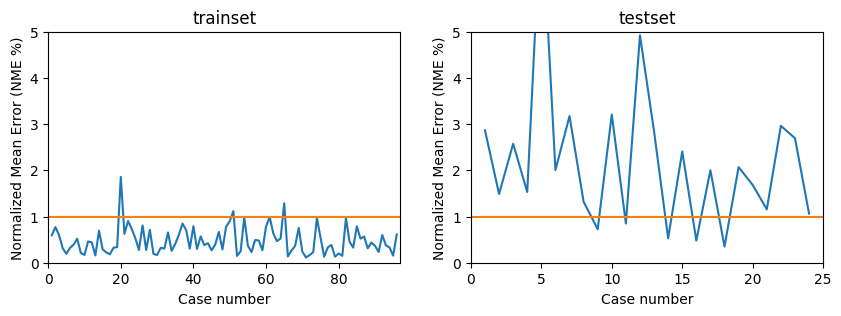

In [11]:
# In[]
def NME(y_true, y_pred):
    return np.sum( abs( (y_pred - y_true) / y_true ) ) / len(y_pred)

result_test = []                                                                                                                                                                                                                                                                                                      
for i in range(len(X_test)):
    result_test.append(NME(pred_test[i][::-1].reshape(-1), y_test[i][::-1].reshape(-1)))

result_train = []                                                                                                                                                                                                                                                                                                              
for i in range(len(X_train)):
    result_train.append(NME(pred_train[i][::-1].reshape(-1), y_train[i][::-1].reshape(-1)))

#
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(np.arange(1,len(X_train)+1,1), np.array(result_train) * 100)
plt.xlim([0,len(X_train)+1])
plt.ylim([0,5])
plt.plot([0,len(X_train)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(np.arange(1,len(X_test)+1,1), np.array(result_test) * 100)
plt.xlim([0,len(X_test)+1])
plt.ylim([0,5])
plt.plot([0,len(X_test)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')

Text(0, 0.5, 'target')

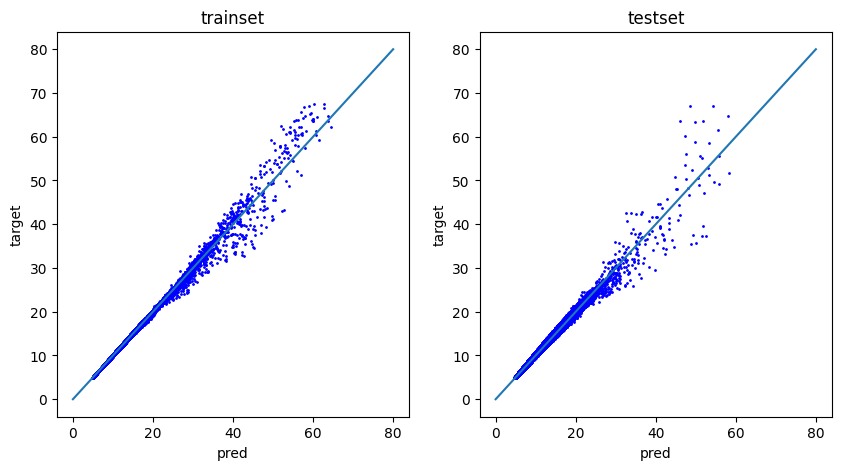

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.reshape(-1), y_test.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')